In [144]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,5,6,7'
import jax
import flax
import jax.numpy as jnp
import pickle
from flax.serialization import from_state_dict
from src.subgoal_diffuser import GCDDPMBCAgent
from src.icvf_networks import LayerNormMLP
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from moviepy.editor import VideoClip
import numpy as np
import seaborn as sns
from moviepy.video.io.bindings import mplfig_to_npimage

In [3]:
DIFF_PATHS = {
    "icvf-params": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvf_param_large-diffusion/params.pkl",
    "ptrajgoal=1": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/random-withintraj_large-diffusion/params.pkl",
    "icvf_weighted-sum": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/withintraj-icvfsumweight-large-diffusion/params.pkl",
    "icvf_weighted-softmax": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvf_weighted-softmax/params.pkl",
    "icvf_weighted-softmax-advstep": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvf_weighted-softmax-advstep/params.pkl",
    "icvf_weighted-reachable": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvfweighted-reachableonly/params.pkl",
    "icvf_weighted-useful": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvfweighted-usefulonly/params.pkl",
    'icvfweight-threshold': '/home/dashora7/experiment_output/icvfweighted-threshold/params.pkl',
    'icvfweight-threshold-randompts': '/home/dashora7/experiment_output/icvfweighted-threshold-randompts/params.pkl',
    'icvfweight-threshold-randompts-unconditional': '/home/dashora7/experiment_output/antmaze-large-diverse-v2/icvfweighted-threshold-randompts-unconditioned/params.pkl',
    'randompts-unconditional': '/home/dashora7/experiment_output/antmaze-large-diverse-v2/randompts-unconditioned/params.pkl',
    'trajpts-unconditional': '/home/dashora7/experiment_output/antmaze-large-diverse-v2/trajpts-unconditioned/params.pkl',
    'trajpts-gc': "/home/dashora7/experiment_output/antmaze-large-diverse-v2/trajpts-gc/params.pkl",
    # CLIPPED MODELS
    'trajpts-gc-clipped': "/home/dashora7/experiment_output/antmaze-large-diverse-v2/trajpts-gc-clipped/params.pkl",
    'trajpts-unconditional-clipped':'/home/dashora7/experiment_output/antmaze-large-diverse-v2/trajpts-unconditioned-clipped/params.pkl',
    'trajpts-gc-clipped-icvfweight-threshold': '/home/dashora7/experiment_output/antmaze-large-diverse-v2/randompts-gc-clipped-icvf_threshold_weight-2/params.pkl'
}

In [157]:
diff_path = DIFF_PATHS["trajpts-gc-clipped-icvfweight-threshold"]
assert diff_path is not None, "Need to provide path to diff model!"    
with open(diff_path, 'rb') as f:
    diff_params = pickle.load(f)

params = diff_params['agent']
conf = diff_params['config']

# define encoder
hidden_dims = (256, 256)
encoder_def = LayerNormMLP(hidden_dims)

# initialize agent
rng = jax.random.PRNGKey(42)
rng, construct_rng = jax.random.split(rng)
agent = GCDDPMBCAgent.create(
    rng=construct_rng,
    observations=jnp.ones((1, 29)),
    goals=jnp.ones((1, 29)),
    actions=jnp.ones((1, 29)),
    encoder_def=encoder_def,
    conditional=True
)
agent = from_state_dict(agent, params)

def generate_subgoal(obs, goal, t=1, n=1):
    if n > 1:
        if obs.ndim == 1:
            obs = jnp.expand_dims(obs, axis=0)
        if goal.ndim == 1:
            goal = jnp.expand_dims(goal, axis=0)
        obs = jnp.repeat(obs, n, axis=0)
        goal = jnp.repeat(goal, n, axis=0)
    return agent.sample_actions(obs, goal, seed=jax.random.PRNGKey(42), temperature=t)
# generate_subgoal = jax.jit(generate_subgoal)

In [77]:
start, end = 804804, 805114
fpath = '/home/dashora7/hard_antmaze.hdf5'
data = h5py.File(fpath, 'r')
obses = data['observations']
exp_slice = obses[start:end]
subgoal_idxs = [0, 30, 50, 90, 115, 135, 150, 175, 200, 225, 260, 285, 309]
goal = exp_slice[-1]

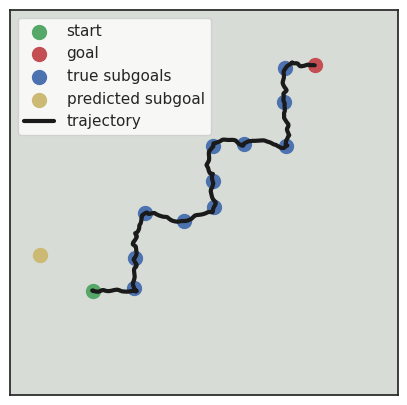

In [78]:
def plot_traj(traj, start, goal, true_subgoals):
    fig, ax = plt.subplots(figsize=(5, 5))
    sg_predicted = generate_subgoal(start, goal)
    ax.set_facecolor('xkcd:light grey')
    ax.grid(True, color='white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(start[0], start[1], c='g', s=100, label='start')
    ax.scatter(goal[0], goal[1], c='r', s=100, label='goal')
    ax.scatter(true_subgoals[:, 0], true_subgoals[:, 1], c='b', s=100, label='true subgoals')
    ax.scatter(sg_predicted[0], sg_predicted[1], c='y', s=100, label='predicted subgoal')
    ax.plot(traj[:, 0], traj[:, 1], c='k', linewidth=3, label='trajectory')
    ax.legend()
    return fig

fig = plot_traj(
    exp_slice,
    exp_slice[0],
    exp_slice[-1],
    exp_slice[subgoal_idxs[1:-1], :2],
)
# set fig limits
fig.axes[0].set_xlim(0, 40)
fig.axes[0].set_ylim(-10, 30)

fig.show()

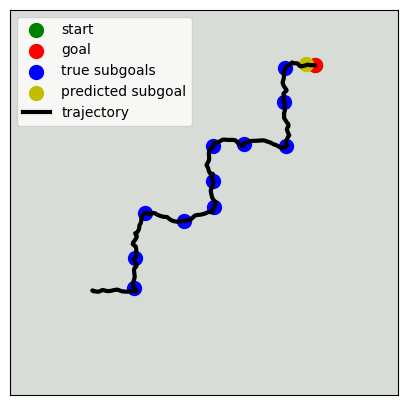

In [ ]:
# make movie by creating plot as we move start position
fig = plot_traj(
    exp_slice,
    exp_slice[0],
    exp_slice[-1],
    exp_slice[subgoal_idxs[1:-1], :2],
)
# set fig limits
fig.axes[0].set_xlim(0, 40)
fig.axes[0].set_ylim(-10, 30)
def animation_func(i):
    # recompute subgoal
    start = exp_slice[i]
    sg_predicted = generate_subgoal(start, goal, t=1)
    # update plot
    fig.axes[0].collections[0].set_offsets(start[:2])
    fig.axes[0].collections[-1].set_offsets(sg_predicted[:2])
    return fig,

anim = animation.FuncAnimation(fig, animation_func, frames=exp_slice.shape[0], interval=100, blit=True)
HTML(anim.to_html5_video())

In [159]:
def plot_heatmap(x, y, s, g, exp_traj, bandwidth=0.2, cmap="viridis", fill=True):
    # Create a 2D KDE plot
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_xlim(-3, 43)
    ax.set_ylim(-4, 30)
    sns.set(style="white")
    plt.imshow(np.zeros((1, 1)), cmap=cmap, vmin=0, vmax=1, extent=[-3, 43, -4, 30])
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=fill, thresh=0, levels=100,
                alpha=1, bw_method=bandwidth)
    #remove ticks
    plt.xticks([])
    plt.yticks([])
    # plot start and goal
    plt.scatter(s[0], s[1], c='white', s=100, label='start')
    plt.scatter(g[0], g[1], c='r', s=100, label='goal')
    plt.plot(exp_traj[:, 0], exp_traj[:, 1], c='k', linewidth=3, label='trajectory')
    # plot squares of maze
    plt.fill_between([-3, 0], [-4, -4], [30, 30], color='xkcd:light grey')
    plt.fill_between([40, 43], [-4, -4], [30, 30], color='xkcd:light grey')
    plt.fill_between([0, 40], [27, 27], [30, 30], color='xkcd:light grey')
    plt.fill_between([0, 40], [-4, -4], [-1, -1], color='xkcd:light grey')
    plt.fill_between([15, 19], [-1, -1], [7, 7], color='xkcd:light grey')
    plt.fill_between([4, 11], [3, 3], [7, 7], color='xkcd:light grey')
    plt.fill_between([0, 3.5], [19, 19], [22.5, 22.5], color='xkcd:light grey')
    plt.fill_between([8, 11], [16, 16], [28, 28], color='xkcd:light grey')
    plt.fill_between([4, 18], [12, 12], [16, 16], color='xkcd:light grey')
    plt.fill_between([15, 19], [12, 12], [23, 23], color='xkcd:light grey')
    plt.fill_between([23, 27], [19, 19], [29, 29], color='xkcd:light grey')
    plt.fill_between([23, 27], [4, 4], [15, 15], color='xkcd:light grey')
    plt.fill_between([23, 35], [11, 11], [15, 15], color='xkcd:light grey')
    plt.fill_between([32, 35], [4, 4], [7, 7], color='xkcd:light grey')
    plt.fill_between([31, 40], [19, 19], [22.5, 22.5], color='xkcd:light grey')
    # trim image
    return fig

FPS = 10

def make_frame(t):
    s = exp_slice[int(FPS * t)]
    g = exp_slice[-1]
    sg_samples = generate_subgoal(s, g, t=1, n=1000)[:, :2]
    x_data = sg_samples[:, 0]
    y_data = sg_samples[:, 1]
    f = plot_heatmap(x_data, y_data, s, g, exp_slice[: :2])
    np_arr = mplfig_to_npimage(f)
    plt.close(f)
    return np_arr

animate = VideoClip(make_frame, duration=(exp_slice.shape[0] / FPS))
animate.ipython_display(fps=FPS, loop=True, autoplay=True)


                                                             
                                                             
t:  15%|█▍        | 45/310 [07:56<03:19,  1.33it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
